# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

Date : 27-07-21

### Loading libs

In [1]:
PATH = '/home/homer/anaconda3/envs/HM/bin/python'
Sys.setenv(RETICULATE_PYTHON = PATH)

current_dir <- getwd()
mogp_dir <- current_dir #mogp_emulator lib : https://github.com/alan-turing-institute/mogp-emulator

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/')) #devel version og ExeterUQ_MOGP : https://github.com/BayesExeter/ExeterUQ_MOGP/tree/devel

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

r_packages <- c('reticulate', 'future.apply', 'tgp', 'ANN2', 'MLmetrics', 'keras')
invisible(lapply(r_packages, library, character.only = TRUE))

use_condaenv("HM")

python_pkg <- c("L96_amip", "numpy", "sklearn", "skopt.sampler", "skopt.space")
python_pkg_names <- c("L96_amip", "np", "sklearn", "sampler", "skSpace")
for(i in seq(length(python_pkg))){assign(python_pkg_names[i], import(python_pkg[i]))}

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘keras’


The following

# History Matching with dimensionality reduction

1. Space filling design of parameters space
2. Data simulation
3. Dimensionality reduction with PCA (EOF) or AE
4. Training of statistical emulator
5. Computation of implausibility
6. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation


In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model.
We then iterate for n_iter iterations and use this history as an observation of the real model.
We save the history of X in order to reinject it during the Y integration.

In [3]:
n_iter <- 10
dt <- 0.001
l96_two$iterate(10)
Newinit = l96_two$X
np$random$seed(as.integer(42))
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 
l96_two$iterate(n_iter)
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [4]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0)))

   user  system elapsed 
  1.916   0.000   1.922 

### Generation of metrics for the first wave

In [5]:
n_samples <- 30

In [6]:
space <- skSpace$Space(list(c(-2, 2), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

In [7]:
extract_metrics_AMIP <- function(p, n_iter, dt, X_hist) {
    initX <- as.matrix(X_hist[1,])
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=10, c=p[[2]], b=p[[3]])
    l96_mip$iterate_AMIP(X_hist, n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0)))
}

In [8]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

In [9]:
metrics_wave1 <- t(metrics_wave1)

## Dimensonality reduction of metrics space
* Generating a test set

In [10]:
n_samples_test <- 30
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))

In [11]:
metrics_test = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

In [12]:
metrics_test <- t(metrics_test)

In [13]:
# Scale metrics
my.scaler <- sklearn$preprocessing$StandardScaler()
X <- my.scaler$fit_transform(metrics_wave1)
X_test <- my.scaler$fit_transform(metrics_test)
input_size = dim(X)[[2]]

### Principal Component Analysis

In [14]:
pca_dim <- 8
pca <- sklearn$decomposition$PCA(n_components=as.integer(pca_dim))
X_pca <- pca$fit_transform(X)
X_pca_test <- pca$transform(X_test)
X_inverse_transform <- pca$inverse_transform(X_pca)
X_test_inverse_transform <- pca$inverse_transform(X_pca_test)
mse <- MSE(X_inverse_transform, X)
val_mse <- MSE(X_test_inverse_transform, X_test)
mse
val_mse

[1] 0.003810737

[1] 0.01240443

### Autoencoder

In [15]:
latent_size <- 32

#Create encoder
enc_input = layer_input(shape = input_size)
enc_output = enc_input %>% 
  layer_dense(units=latent_size, activation = "tanh") 
encoder = keras_model(enc_input, enc_output)

#Create decoder
dec_input = layer_input(shape = latent_size)
dec_output = dec_input %>% 
  layer_dense(units = input_size, activation = "linear") #%>%
  #layer_dropout(rate=0.2)
decoder = keras_model(dec_input, dec_output)

#Create autoencoder
aen_input = layer_input(shape = input_size)
aen_output = aen_input %>% 
  encoder() %>% 
  decoder()
   
ae = keras_model(aen_input, aen_output)
summary(ae)

Model: "model_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                [(None, 2340)]                  0           
________________________________________________________________________________
model (Functional)                  (None, 32)                      74912       
________________________________________________________________________________
model_1 (Functional)                (None, 2340)                    77220       
Total params: 152,132
Trainable params: 152,132
Non-trainable params: 0
________________________________________________________________________________


In [16]:
ae %>% compile(optimizer="Adam", loss="mean_squared_error")
ae %>% fit(X,X, epochs=600, batch_size=16, validation_data =list(X_test, X_test))

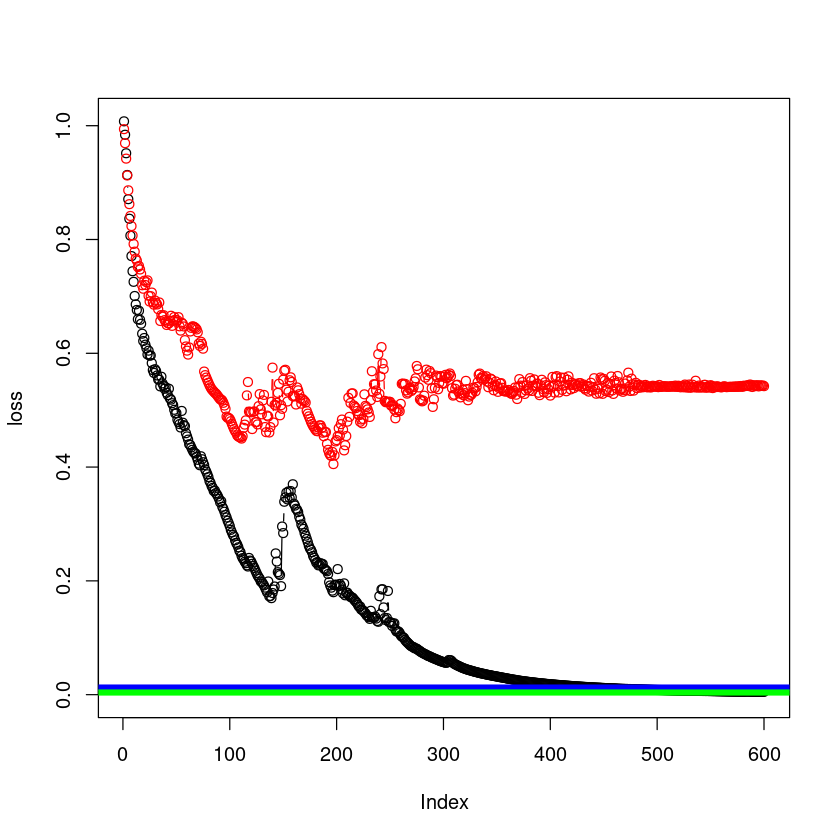

In [17]:
loss <- ae$history$history$loss
val.loss <- ae$history$history$val_loss
max.loss <- max(c(loss, val.loss))
plot(loss, type='b', ylim=c(0, max.loss))
lines(val.loss, col='red', type='b')
abline(h=val_mse, col='blue', lwd=5)
abline(h=mse, col='green', lwd=5)
legend(700, 1, legend=c("AE mse", "AE val mse", "PCA mse", "PCA val mse"), 
       col=c('black', 'red', 'blue', 'green'),
       lty=1:4,
       title="Losses")


Artificial Neural Network: 
  Layer - 2340 nodes - input 
  Layer - 64 nodes - tanh 
  Layer - 2340 nodes - linear 
With squared loss and Adam optimizer 
Training progress:
[++++++++++++++++++++++++++++++++++++++++++++++++++] 100% - Training loss: 181.499


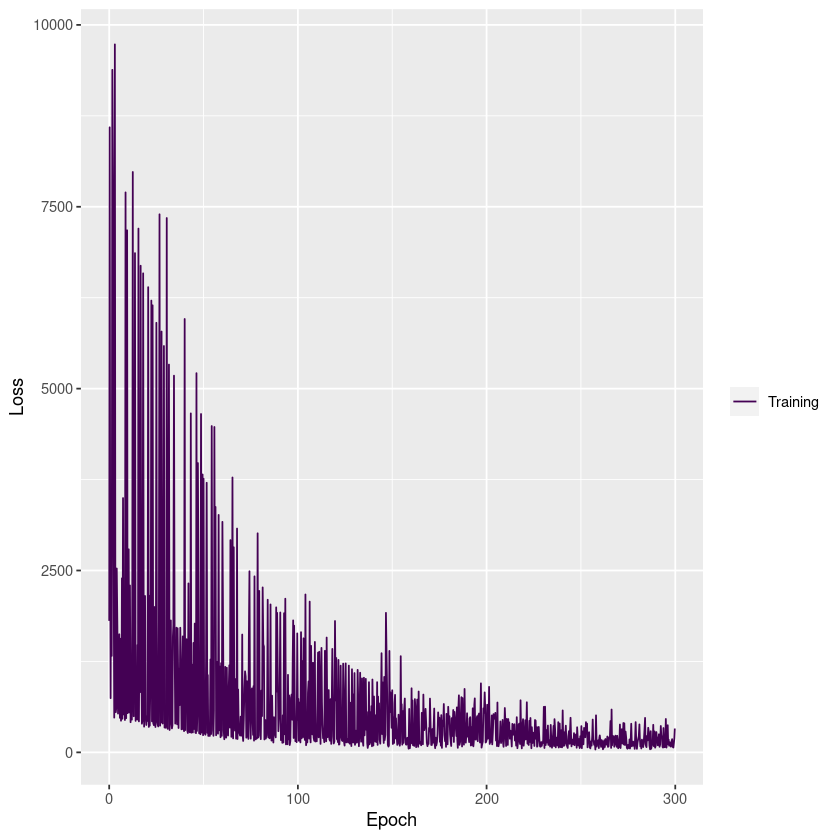

In [18]:
bottleneck.size <- 64
AE <- autoencoder(X, c(bottleneck.size), loss.type = 'squared',
                  activ.functions = c('tanh'),
                  batch.size = 5, optim.type = 'adam',
                  n.epochs = 300, val.prop = 0)

plot(AE)

In [19]:
MSE(decode(AE,encode(AE,X_test)), X_test)

[1] 0.2509625

### Create the data matrix

In [20]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [21]:
#Inputs scaling
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'c', 'b')

#Classic metrics with k=0
k <- 0 # Select k in K for tunning 
metrics_index_k <- (k*65+1):((k+1)*65)
metrics_k_wave1 <- data.frame(metrics_wave1[, metrics_index_k])
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_k_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"

#Reduced data
tData_pca <- data.frame(cbind(inputs_wave1, noise, X_pca))
names(tData_pca)[names(tData_pca) == "noise"] <- "Noise"

X_ae <- encoder %>% predict(X)
tData_ae <- data.frame(cbind(inputs_wave1, noise, X_ae))
names(tData_ae)[names(tData_ae) == "noise"] <- "Noise"

X_auto <- encode(AE, X)
tData_auto <- data.frame(cbind(inputs_wave1, noise, X_auto))
names(tData_auto)[names(tData_auto) == "noise"] <- "Noise"

### Training emulator

In [22]:
cands <- names(tData)[1:3]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_k_wave1), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_pca <- BuildNewEmulators(tData_pca, HowManyEmulators = ncol(X_pca), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_ae <- BuildNewEmulators(tData_ae, HowManyEmulators = ncol(X_ae), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_auto <- BuildNewEmulators(tData_auto, HowManyEmulators = ncol(X_auto), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0324866889484487 using h"
[1] "Max reduction is 0.0080462388123647 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + b + I(b * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.301661 -0.043256  0.003435  0.036234  0.284406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.004889   0.018315  -0.267   0.7916    
h            0.159587   0.032470   4.915 4.21e-05 ***
b            0.081021   0.031912   2.539   0.0174 *  
I(b * h)     0.013509   0.062711   0.215   0.8311    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1003 on 26 degrees of freedom
Multiple R-squared:  0.5452,	Adjusted R-squared:  0.4928 
F-statistic: 10.39 on 3 and 26 DF,  p-value: 0.0001132

[1] "Max reduction is 0.0945718566703141 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h, data = tData)

Residuals:
      Min        1Q

[1] "Max reduction is 0.294498105924767 using h"
[1] "Max reduction is 6.41706875222655 using h"
[1] "Max reduction is 1.88739961625129 using c"
[1] "Max reduction is 1.63867106350822 using Three Way Interactions with h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + I(h^2) + c + I(c * h) + I(h * c * h), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-66.114 -15.669  -1.564  11.890  95.568 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -27.884      9.335  -2.987 0.006400 ** 
h             -19.255     10.866  -1.772 0.089093 .  
I(h^2)         90.334     21.963   4.113 0.000396 ***
c             -17.445     17.765  -0.982 0.335898    
I(c * h)      -46.517     19.793  -2.350 0.027321 *  
I(h * c * h)   91.705     48.844   1.878 0.072652 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.25 on 24 degrees of freedom
Multiple R-squared:  0.5162,	Adjusted R-square

[1] "Max reduction is 0.454376094347585 using h"
[1] "Max reduction is 0.0854843581370361 using h"
[1] "Max reduction is 0.0426497525573449 using h"
[1] "Max reduction is 0.0870067904303193 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + I(h^2) + I(h^3) + I(h^4), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65836 -0.12896 -0.00585  0.16421  0.63856 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.84070    0.09765   8.609 6.01e-09 ***
h           -2.20894    0.23174  -9.532 8.36e-10 ***
I(h^2)      -3.73562    0.65249  -5.725 5.79e-06 ***
I(h^3)       1.39752    0.36866   3.791 0.000846 ***
I(h^4)       3.40678    0.77017   4.423 0.000166 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2814 on 25 degrees of freedom
Multiple R-squared:  0.9245,	Adjusted R-squared:  0.9124 
F-statistic: 76.55 on 4 and 25 DF,  p-value: 1.179e-13

[1] "No permitt

[1] "Max reduction is 0.174831731918467 using h"
[1] "Max reduction is 0.0337660385215226 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = node_1 ~ h + I(h^2), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.80121 -0.11297 -0.01552  0.08876  0.91707 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1953     0.0881  -2.217   0.0353 *  
h            -0.6825     0.1020  -6.694 3.47e-07 ***
I(h^2)        0.5452     0.2026   2.691   0.0121 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.319 on 27 degrees of freedom
Multiple R-squared:  0.6596,	Adjusted R-squared:  0.6344 
F-statistic: 26.16 on 2 and 27 DF,  p-value: 4.799e-07

[1] "Max reduction is 0.00873792251286903 using h"
[1] "Max reduction is 0.0515793433233367 using h"
[1] "Max reduction is 0.021093311048261 using c"
[1] "Max reduction is 0.00969905690400069 using Three Way Interactions with h"
[1] "No

### Compute implausibility

In [23]:
tDisc <- rep(0, ncol(metrics_k_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_k_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations[metrics_index_k]) # Observations

obs_scaled <- my.scaler$transform(t(data.frame(observations)))

tDisc_pca <- rep(0, ncol(X_pca)) # model discrepancy variance Var[g] 
tObsErr_pca <- rep(0, ncol(X_pca)) # observational error variance Var[e]
tObs_pca <-  pca$transform(obs_scaled) # Observations with pca

tDisc_ae <- rep(0, ncol(X_ae)) # model discrepancy variance Var[g] 
tObsErr_ae <- rep(0, ncol(X_ae)) # observational error variance Var[e]
tObs_ae <-  encoder %>% predict(obs_scaled) # Observations with kerras ae

tDisc_auto <- rep(0, ncol(X_auto)) # model discrepancy variance Var[g] 
tObsErr_auto <- rep(0, ncol(X_auto)) # observational error variance Var[e]
tObs_auto <-  encode(AE, obs_scaled) # Observations with ANN2 ae

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [24]:
sample_size <- 50000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)

In [25]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))
system.time(Timps_pca <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1_pca, Discrepancy=tDisc_pca, Obs=tObs_pca, ObsErr=tObsErr_pca))
system.time(Timps_ae <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1_ae, Discrepancy=tDisc_ae, Obs=tObs_ae, ObsErr=tObsErr_ae))
system.time(Timps_auto <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1_auto, Discrepancy=tDisc_auto, Obs=tObs_auto, ObsErr=tObsErr_auto))

   user  system elapsed 
 30.991   5.950   6.641 

   user  system elapsed 
  2.287   1.798   1.317 

   user  system elapsed 
 10.947   2.963   2.696 

   user  system elapsed 
 26.795   3.491   5.579 

In [26]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h c   b
1 0.5 0 0.5


In [27]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
NROY_pca <- which(rowSums(Timps_pca <= cutoff) >= em_wave1_pca$mogp$n_emulators -valmax)
NROY_ae <- which(rowSums(Timps_ae <= cutoff) >= em_wave1_ae$mogp$n_emulators -valmax)
NROY_auto <- which(rowSums(Timps_auto <= cutoff) >= em_wave1_auto$mogp$n_emulators -valmax)


scoreNROY <- length(NROY1)/dim(Xp)[1]
scoreNROY_pca <- length(NROY_pca)/dim(Xp)[1]
scoreNROY_ae <- length(NROY_ae)/dim(Xp)[1]
scoreNROY_auto <- length(NROY_auto)/dim(Xp)[1]

### Layout of NROY space

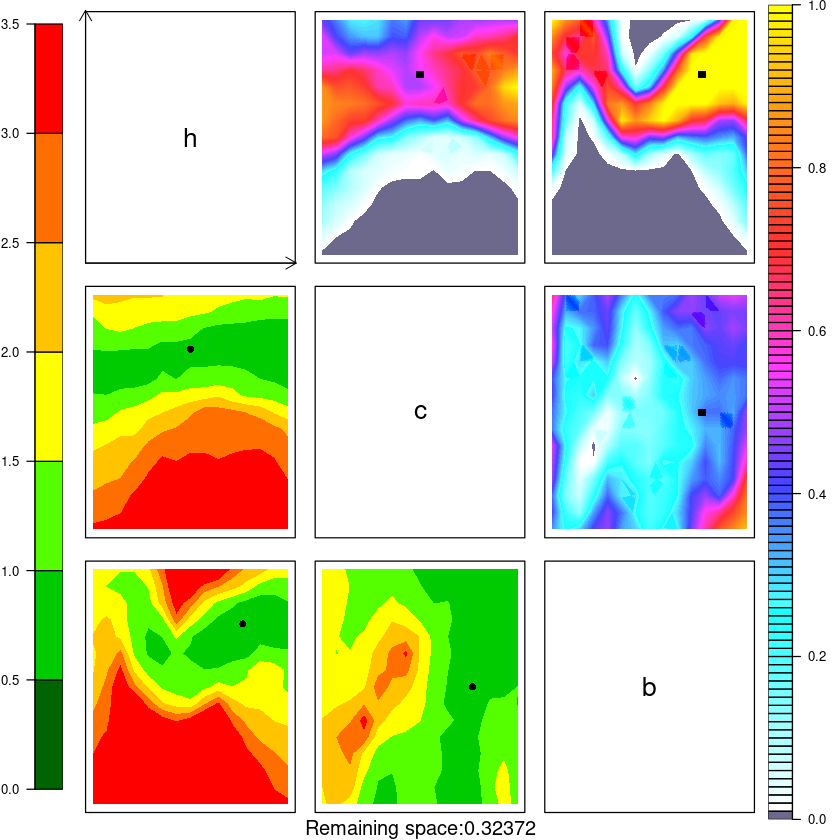

In [28]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY,sep=""), side=1)

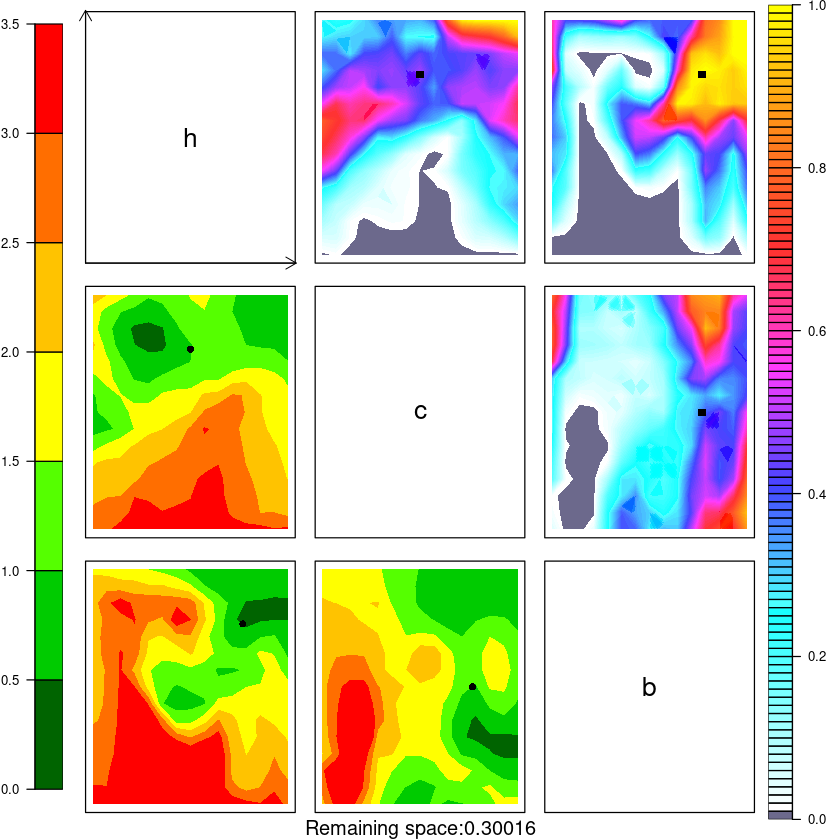

In [29]:
ImpData_wave1_pca = cbind(Xp, Timps_pca)
ImpListM1_pca = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1_pca, nEms=em_wave1_pca$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1_pca,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY_pca,sep=""), side=1)

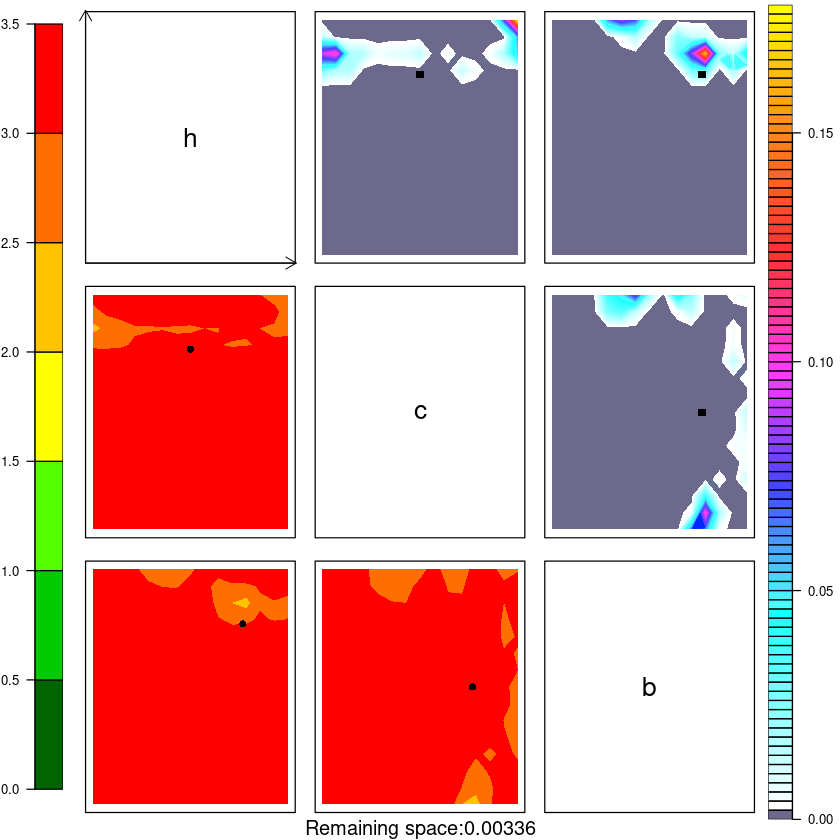

In [30]:
ImpData_wave1_ae = cbind(Xp, Timps_ae)
ImpListM1_ae = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1_ae, nEms=em_wave1_ae$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1_ae,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY_ae,sep=""), side=1)

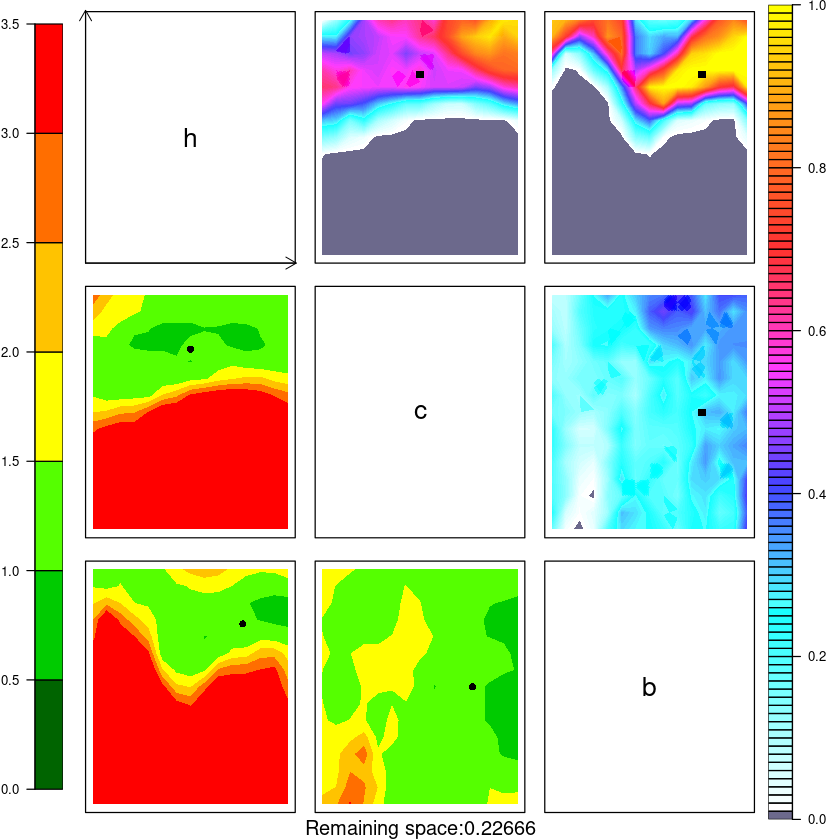

In [31]:
ImpData_wave1_auto = cbind(Xp, Timps_auto)
ImpListM1_auto = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1_auto, nEms=em_wave1_auto$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1_auto,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY_auto,sep=""), side=1)